TensorFlow version: 2.19.0
Exemple de ligne :
                                                path  label
0  landed,down,down,TRUE;landed,down,moving,FALSE...      1
✅ Données prêtes : X.shape = (1069, 5, 4) , y.shape = (1069,)
Répartition des classes dans les labels :
  Classe 0 : 503 exemples
  Classe 1 : 566 exemples
✅ Données divisées :
  Entraînement : (855, 5, 4)
  Test        : (214, 5, 4)

📂 Fold 1 =============================
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Accuracy: 0.9766355140186916
AUC: 0.9984929078014185
Confusion matrix:
[[ 90   4]
 [  1 119]]

📂 Fold 2 =============================
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Accuracy: 0.8411214953271028
AUC: 0.9485032074126871
Confusion matrix:
[[87  5]
 [29 93]]

📂 Fold 3 =============================
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Accuracy: 0.9906542056074766
AUC: 0.9996445392339821
Confusion matrix:
[[ 91   2]
 [  0 121]]

📂 Fold 4 =============================
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy: 

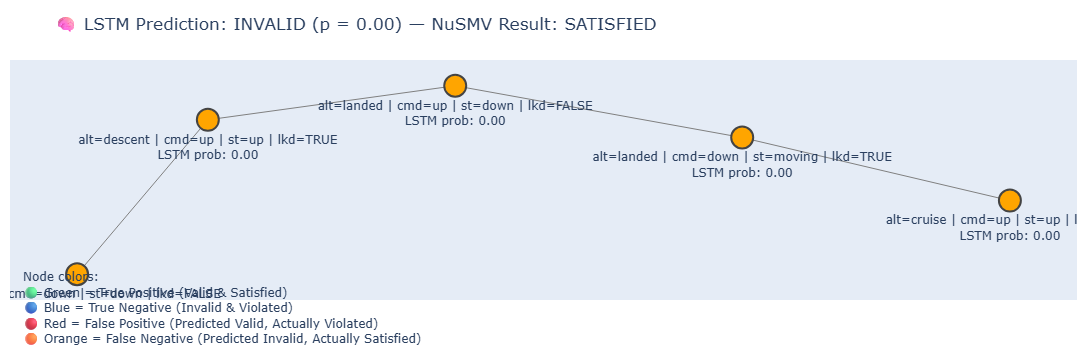

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
✔️  La propriété est VRAIE sur le chemin décrit dans generated_path.smv


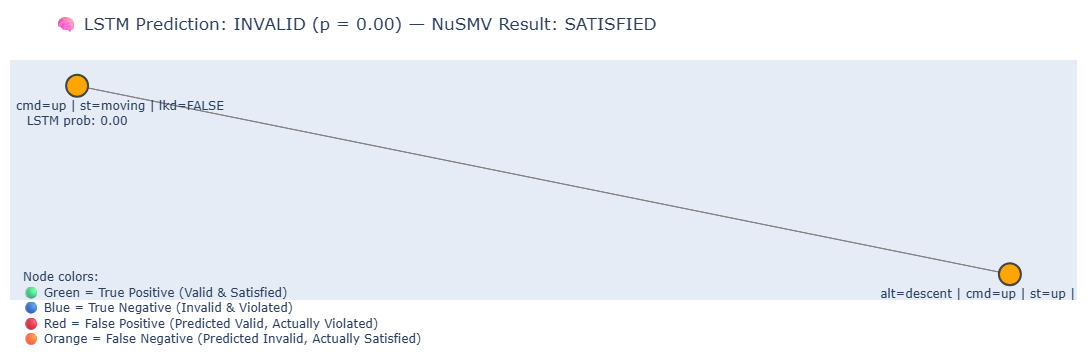

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
❌ La propriété est FAUSSE sur le chemin décrit dans generated_path.smv
❌ Violation trouvée, arrêt vérification


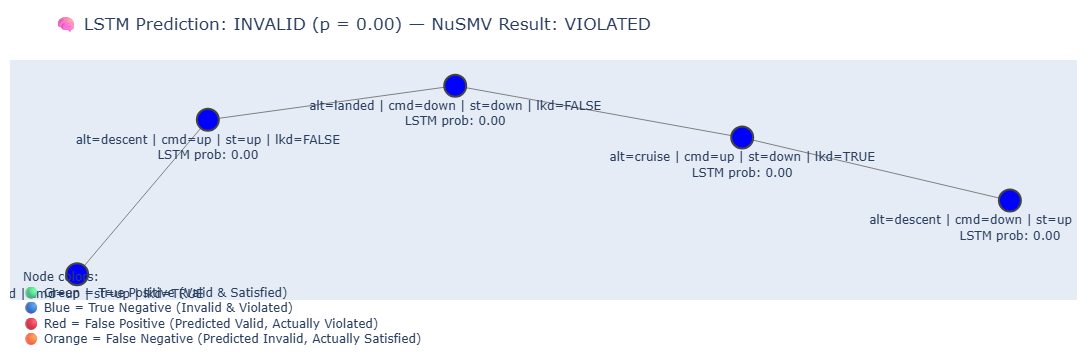

🔍 proba = 5.9961993e-05   — pred = 0
✅ Patch proposé généré dans : patched_model.smv
✔️  La propriété est VRAIE sur le chemin décrit dans patched_model.smv
r11 [[2, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 0, 1, 1], [1, 0, 1, 1]]
✔️  La propriété est VRAIE sur le chemin décrit dans generated1_path.smv
correction


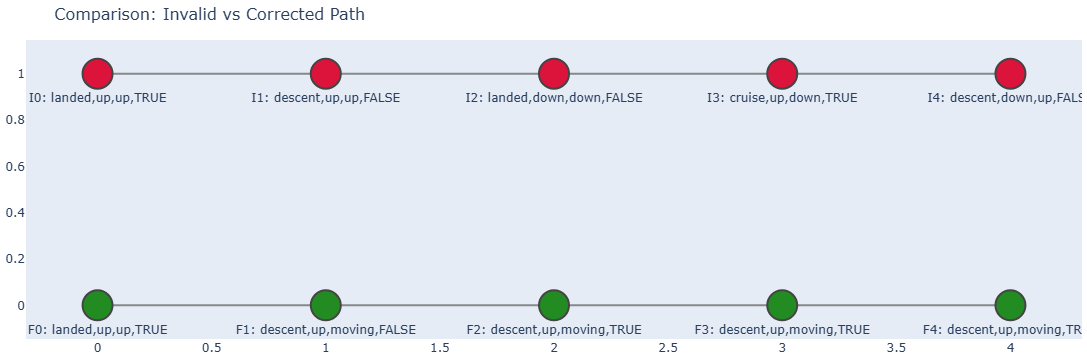

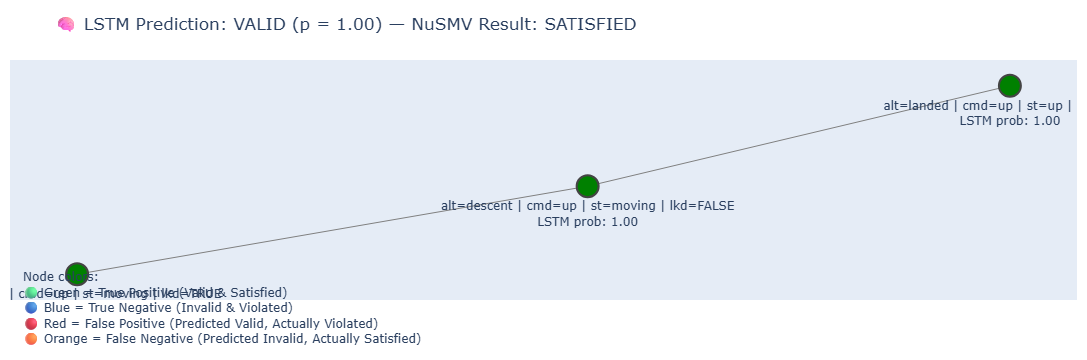

PermissionError: [Errno 13] Permission denied: 'rapport_lstm.pdf'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from fpdf import FPDF
import os
import subprocess
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# === PARAMÈTRES ===
FILENAME = "dataset_paths_balanced.csv"
SEQUENCE_LENGTH = 5
FEATURES_PER_STEP = 4
N_FOLDS = 5
EPOCHS = 20
BATCH_SIZE = 32

# === 1. Chargement des données ===
df = pd.read_csv(FILENAME)
print("Exemple de ligne :")
print(df.head(1))

# === 2. Référentiels ===
altitudes = ["cruise", "descent", "landed"]
gear_cmds = ["up", "down"]
gear_states = ["up", "moving", "down"]
gear_locked = ["TRUE", "FALSE"]

# === 3. Parsing ===
def parse_path(path_str):
    steps = path_str.strip().split(";")
    return [step.split(",") for step in steps]

df["parsed"] = df["path"].apply(parse_path)

# === 4. Validation ===
VALID_ALTITUDES = set(altitudes)
VALID_CMDS = set(gear_cmds)
VALID_STATES = set(gear_states)
VALID_LOCKS = set(gear_locked)

def is_valid_step(step):
    return (
        len(step) == 4 and
        step[0] in VALID_ALTITUDES and
        step[1] in VALID_CMDS and
        step[2] in VALID_STATES and
        step[3] in VALID_LOCKS
    )

def is_valid_path(path):
    return all(is_valid_step(step) for step in path)

df["valid"] = df["parsed"].apply(is_valid_path)
df = df[df["valid"]].copy()

# === 5. Filtrage : uniquement les chemins de longueur ≤ SEQUENCE_LENGTH
df = df[df["parsed"].apply(lambda x: len(x) <= SEQUENCE_LENGTH)].copy()

# === 6. Encodage ===
from sklearn.preprocessing import LabelEncoder
enc_alt = LabelEncoder().fit(altitudes)
enc_cmd = LabelEncoder().fit(gear_cmds)
enc_state = LabelEncoder().fit(gear_states)
enc_lock = LabelEncoder().fit(gear_locked)

def encode_path(path):
    return [
        [
            enc_alt.transform([step[0]])[0],
            enc_cmd.transform([step[1]])[0],
            enc_state.transform([step[2]])[0],
            enc_lock.transform([step[3]])[0],
        ]
        for step in path
    ]

def pad_path(path, max_len):
    pad_len = max_len - len(path)
    return path + [[0, 0, 0, 0]] * pad_len

df["encoded"] = df["parsed"].apply(encode_path)
df["padded"] = df["encoded"].apply(lambda x: pad_path(x, SEQUENCE_LENGTH))

# === 7. Conversion numpy ===
import numpy as np
df["padded_shape"] = df["padded"].apply(lambda x: np.array(x).shape)
df = df[df["padded_shape"] == (SEQUENCE_LENGTH, FEATURES_PER_STEP)].copy()

X = np.array(df["padded"].tolist())
y = np.array(df["label"])

print("✅ Données prêtes : X.shape =", X.shape, ", y.shape =", y.shape)

# === 8. Vérification de la distribution des classes ===
print("Répartition des classes dans les labels :")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Classe {label} : {count} exemples")

# === 9. Split train / test avec stratification ===
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Données divisées :")
print("  Entraînement :", X_train.shape)
print("  Test        :", X_test.shape)

# === 3. Modèle LSTM ===
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, FEATURES_PER_STEP)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# === 4. Cross-validation ===
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
metrics = []

if not os.path.exists("plots"):
    os.makedirs("plots")

fold_no = 1
models = []  # stocker les modèles si besoin

for train_index, test_index in kf.split(X):
    print(f"\n📂 Fold {fold_no} =============================")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model()
    early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0,
    )

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

    acc = np.mean(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred_prob)

    print("Accuracy:", acc)
    print("AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    model.save(f"model_fold_{fold_no}.keras")
    models.append(model)

    # Enregistrement des métriques
    metrics.append({
        "fold": fold_no,
        "accuracy": acc,
        "auc": auc
    })

    # Courbe d’apprentissage
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.title(f"Accuracy Fold {fold_no}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title(f"Loss Fold {fold_no}")
    plt.legend()

    plot_path = f"plots/learning_fold_{fold_no}.png"
    plt.savefig(plot_path)
    plt.close()

    fold_no += 1

print("\n📦 Entraînement final sur **toutes** les données")

# 1. Recréer un nouveau modèle
final_model = create_model()

# 2. Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# 3. Entraînement sur toutes les données (avec validation interne)
history = final_model.fit(
    X,
    y,
    validation_split=0.1,  # petite validation interne
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# 4. Sauvegarde du modèle final
final_model.save("final_model_trained_on_all_data.keras")

# === AJOUT : fonction de filtrage et priorisation ===
def filter_and_prioritize_paths(model, X_paths, threshold=0.5):
    """
    Filtrer les chemins invalides probables et prioriser ceux à vérifier.
    
    Args:
        model: modèle LSTM entraîné (keras)
        X_paths: np.array, chemins encodés
        threshold: float, seuil de probabilité minimum pour garder un chemin
    
    Returns:
        filtered_paths: chemins à vérifier (prob valide >= threshold)
        prioritized_paths: filtered_paths triés par prob invalide décroissante
    """
    probs = model.predict(X_paths)[:, 0]  # probabilité que le chemin soit valide
    
    # Filtrer les chemins : prob valide >= threshold
    filtered_indices = np.where(probs >= threshold)[0]
    filtered_paths = X_paths[filtered_indices]
    
    # Prioriser les chemins par probabilité d'invalidation décroissante
    prioritized_indices = filtered_indices[np.argsort(1 - probs[filtered_indices])[::-1]]
    prioritized_paths = X_paths[prioritized_indices]
    
    return filtered_paths, prioritized_paths


# === EXEMPLE D'UTILISATION ===
# On prend le dernier modèle entraîné (fold 5 ici)
model_for_filtering = models[-1]

print("\n  Exemple de filtrage et priorisation des chemins simulés")

# Supposons qu'on a des chemins simulés à vérifier, ici on reprend tout X comme exemple
X_simulated = X  # à remplacer par tes chemins simulés à tester

threshold = 0.6
filtered_paths, prioritized_paths = filter_and_prioritize_paths(model_for_filtering, X_simulated, threshold)

print(f"Nombre de chemins simulés : {len(X_simulated)}")
print(f"Nombre après filtrage (prob valide >= {threshold}) : {len(filtered_paths)}")

# Pseudocode d'appel NuSMV :
def create_smv_from_decoded_path(decoded_path, output_file):
    """
    Génère un fichier SMV décrivant le chemin d'états décodé.

    decoded_path : liste de tuples/lists (phase_idx, handle_idx, gear_idx, gear_locked_int)
        Chaque élément décrit un état codé par indices.
    output_file : str
        Chemin du fichier SMV à écrire.
    """

    if not decoded_path:
        raise ValueError("decoded_path est vide")

    n = len(decoded_path)

    PHASES = ['cruise', 'descent', 'landed']
    HANDLES = ['up', 'down']
    GEARS = ['up', 'moving', 'down']

    header = """MODULE main
VAR
  phase : {cruise, descent, landed};
  handle : {up, down};
  gear : {up, moving, down};
  gear_locked : boolean;

"""

    init_block = f"""ASSIGN
  init(phase) := {PHASES[decoded_path[0][0]]};
  init(handle) := {HANDLES[decoded_path[0][1]]};
  init(gear) := {GEARS[decoded_path[0][2]]};
  init(gear_locked) := {'TRUE' if decoded_path[0][3] == 1 else 'FALSE'};

"""

    transitions = ""

    for i, varname, values in [
        (0, "phase", PHASES),
        (1, "handle", HANDLES),
        (2, "gear", GEARS),
    ]:
        transitions += f"  next({varname}) := case\n"
        for t in range(n - 1):
            condition = (
                f"    phase = {PHASES[decoded_path[t][0]]} & "
                f"handle = {HANDLES[decoded_path[t][1]]} & "
                f"gear = {GEARS[decoded_path[t][2]]} & "
                f"gear_locked = {'TRUE' if decoded_path[t][3] == 1 else 'FALSE'}"
            )
            transitions += f"{condition} : {values[decoded_path[t+1][i]]};\n"
        transitions += f"    TRUE : {varname};\n"
        transitions += "  esac;\n\n"

    transitions += "  next(gear_locked) := case\n"
    for t in range(n - 1):
        condition = (
            f"    phase = {PHASES[decoded_path[t][0]]} & "
            f"handle = {HANDLES[decoded_path[t][1]]} & "
            f"gear = {GEARS[decoded_path[t][2]]} & "
            f"gear_locked = {'TRUE' if decoded_path[t][3] == 1 else 'FALSE'}"
        )
        next_val = 'TRUE' if decoded_path[t + 1][3] == 1 else 'FALSE'
        transitions += f"{condition} : {next_val};\n"
    transitions += "    TRUE : gear_locked;\n"
    transitions += "  esac;\n\n"

    spec = "SPEC AG (handle = down -> AF gear_locked = TRUE);\n"

    with open(output_file, "w") as f:
        f.write(header + init_block + transitions + spec)
def print_smv_file_from_decoded_path(decoded_path, output_file):
    # Génère le fichier SMV
    create_smv_from_decoded_path(decoded_path, output_file)

    # Lis et affiche le contenu du fichier généré
    with open(output_file, 'r') as f:
        content = f.read()
        print("Contenu du fichier SMV généré :\n")
        print(content)


# Exemple d'utilisation
decoded_path = [
    [0, 0, 1, 0],  # cruise, up, moving, FALSE
    [1, 0, 1, 0],  # descent, up, moving, FALSE
    [1, 0, 0, 1],  # descent, up, up, TRUE
    [0, 1, 2, 0],  # cruise, down, down, FALSE
    [0, 1, 2, 0]   # cruise, down, down, FALSE
]

output_file = "example.smv"

def encode_symbolic_path(path_symb):
    """
    Encode un chemin symbolique en valeurs entières selon les référentiels.

    Args:
        path_symb (List[List[str]]): chemin sous forme [['descent','up','moving','FALSE'], ...]

    Returns:
        path_encoded (List[List[int]]): chemin encodé ex : [[1, 0, 1, 0], ...]
    """
    # Dictionnaires de correspondance
    altitude_map    = {"cruise": 0, "descent": 1, "landed": 2}
    handle_map      = {"up": 0, "down": 1}
    gear_map        = {"up": 0, "moving": 1, "down": 2}
    locked_map      = {"FALSE": 0, "TRUE": 1}

    path_encoded = []
    for state in path_symb:
        encoded_state = [
            altitude_map.get(state[0], -1),
            handle_map.get(state[1], -1),
            gear_map.get(state[2], -1),
            locked_map.get(state[3], -1)
        ]
        if -1 in encoded_state:
            raise ValueError(f"Invalid value in state: {state}")
        path_encoded.append(encoded_state)

    return path_encoded

def decode_full_path(encoded_path):
    # Tables de décodage corrigées
    PHASES_INV = {0: "cruise", 1: "descent", 2: "landed"}
    HANDLES_INV = {0: "up", 1: "down"}
    GEARS_INV = {0: "up", 1: "moving", 2: "down"}  # ✅ corrigé ici
    GEAR_LOCKED_INV = {0: "FALSE", 1: "TRUE"}

    decoded_path = []

    for state in encoded_path:
        decoded_state = [
            PHASES_INV.get(state[0], "UNKNOWN"),
            HANDLES_INV.get(state[1], "UNKNOWN"),
            GEARS_INV.get(state[2], "UNKNOWN"),
            GEAR_LOCKED_INV.get(state[3], "UNKNOWN")
        ]
        decoded_path.append(decoded_state)

    return decoded_path

import subprocess
import os

def check_path_with_nusmv(smv_file):
    if not os.path.isfile(smv_file):
        print(f"❌ Le fichier {smv_file} n'existe pas.")
        return None

    try:
        result = subprocess.run(["nusmv", smv_file], capture_output=True, text=True, check=True)
        output = result.stdout
        
        # Exemple de parsing un peu plus robuste
        if "is true" in output:
            print(f"✔️  La propriété est VRAIE sur le chemin décrit dans {smv_file}")
            return True
        elif "is false" in output:
            print(f"❌ La propriété est FAUSSE sur le chemin décrit dans {smv_file}")
            return False
        else:
            print(f"⚠️ Résultat NuSMV non reconnu pour le fichier {smv_file}")
            print("Sortie brute :", output)
            return None

    except FileNotFoundError:
        print("❌ NuSMV n'est pas installé ou n'est pas dans le PATH.")
        return None
    except subprocess.CalledProcessError as e:
        print(f"❌ Erreur lors de l'exécution de NuSMV sur {smv_file}")
        print(e.stderr)
        return None

def decode_encoded_path(encoded_path):
    decoded_path = []

    for i, state in enumerate(encoded_path):
        try:
            phase = state[0]       # entier : 0, 1, 2
            handle = state[1]      # entier : 0, 1
            gear = state[2]        # entier : 0, 1, 2
            gear_locked = state[3] # entier : 0, 1
        except IndexError:
            raise ValueError(f"Valeur hors index dans l’état encodé : {state}")

        decoded_path.append([phase, handle, gear, gear_locked])

    return decoded_path



import networkx as nx
import plotly.graph_objects as go

# Déclaration globale des noms de variables
var_names = ["altitude", "gear_cmd", "gear_state", "gear_locked"]

def etat_to_label(etat):
    """
    Convertit une liste d'état ['descent', 'up', 'up', 'TRUE']
    en label lisible : "altitude=descent | gear_cmd=up | ..."
    """
    return ' | '.join(f"{var}={val}" for var, val in zip(var_names, etat))


# Abréviations
var_names = ["alt", "cmd", "st", "lkd"]

def etat_to_label(etat):
    return ' | '.join(f"{var}={val}" for var, val in zip(var_names, etat))

def visualiser_chemin_avec_confusion(chemin, proba, result_nusmv, seuil=0.5):
    """
    Visualize a system path with LSTM prediction and NuSMV result.
    - Node colors reflect prediction correctness.
    - Hover shows variable values and LSTM probability.
    """

    G = nx.DiGraph()
    etats_label = [etat_to_label(e) for e in chemin]

    # Ajouter transitions
    for i in range(len(etats_label) - 1):
        G.add_edge(etats_label[i], etats_label[i + 1])

    # Positionnement du graphe
    pos = nx.spring_layout(G, seed=42)

    # Tracer les arêtes (transitions)
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    # Déterminer classes
    predicted_class = 1 if proba >= seuil else 0
    real_class = 1 if result_nusmv else 0

    # Tracer les nœuds
    node_x, node_y, node_color, node_text = [], [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Couleur selon type de prédiction
        if predicted_class == 1 and real_class == 1:
            color = "green"     # True Positive
        elif predicted_class == 0 and real_class == 0:
            color = "blue"      # True Negative
        elif predicted_class == 1 and real_class == 0:
            color = "red"       # False Positive
        else:
            color = "orange"    # False Negative

        node_color.append(color)
        node_text.append(f"{node}<br>LSTM prob: {proba:.2f}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='bottom center',
        hoverinfo='text',
        marker=dict(
            color=node_color,
            size=22,
            line_width=2
        )
    )

    # Titre dynamique
    pred_label = "VALID" if predicted_class == 1 else "INVALID"
    real_label = "SATISFIED" if real_class == 1 else "VIOLATED"
    title = f"🧠 LSTM Prediction: {pred_label} (p = {proba:.2f}) — NuSMV Result: {real_label}"

    # Annotation = légende explicite
    legend_text = (
        "Node colors:<br>"
        "🟢 Green = True Positive (Valid & Satisfied)<br>"
        "🔵 Blue = True Negative (Invalid & Violated)<br>"
        "🔴 Red = False Positive (Predicted Valid, Actually Violated)<br>"
        "🟠 Orange = False Negative (Predicted Invalid, Actually Satisfied)"
    )

    fig = go.Figure(data=[edge_trace, node_trace],
        layout=go.Layout(
            title=title,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=60, l=10, r=10, t=60),
            annotations=[
                dict(
                    text=legend_text,
                    showarrow=False,
                    align="left",
                    xref="paper", yref="paper",
                    x=0.01, y=-0.2,
                    font=dict(size=12)
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False, visible=False),
            yaxis=dict(showgrid=False, zeroline=False, visible=False)
        )
    )

    fig.show()

def visualiser_chemins_systeme_v3(chemins, probas):
    G = nx.DiGraph()

    # Ajout des nœuds et des transitions
    for chemin, proba in zip(chemins, probas):
        etats_label = [etat_to_label(e) for e in chemin]
        for i in range(len(etats_label) - 1):
            G.add_edge(etats_label[i], etats_label[i+1], proba=proba)

    pos = nx.spring_layout(G, seed=42)

    # Arêtes
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    # Nœuds
    node_x, node_y, node_color, node_text = [], [], [], []
    node_proba_map = {node: [] for node in G.nodes()}

    for chemin, proba in zip(chemins, probas):
        for etat in chemin:
            label = etat_to_label(etat)
            node_proba_map[label].append(proba)

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        moyenne = sum(node_proba_map[node]) / len(node_proba_map[node])
        node_color.append(moyenne)
        node_text.append(f"{node}<br>p={moyenne:.2f}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='bottom center',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='RdYlGn',
            reversescale=False,
            color=node_color,
            size=20,
            colorbar=dict(
                thickness=15,
                title='Probabilité valide (LSTM)',
                xanchor='left',
                titleside='right'
            ),
            line_width=2)
    )

    fig = go.Figure(data=[edge_trace, node_trace],
        layout=go.Layout(
            title='Visualisation des chemins simulés',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            annotations=[dict(
                text="Nœud = état du système | Couleur = prédiction LSTM",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002)],
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False))
    )
    fig.show()
chemin1 = [
    ['descent', 'up', 'up', 'TRUE'],
    ['cruise', 'down', 'down', 'FALSE'],
    ['descent', 'up', 'moving', 'FALSE'],
    ['descent', 'up', 'up', 'TRUE'],
    ['cruise', 'down', 'down', 'FALSE']
]

chemins = [chemin1]
probas = [0.87]  # prédiction associée à ce chemin

# visualiser_chemins_systeme_v3(chemins, probas)
def predict_single_path(model, path_steps):
    """
    Prédit si un chemin est valide ou non.

    Args:
        model: modèle LSTM entraîné
        path_steps: list de listes, chaque étape comme ["altitude", "cmd", "state", "locked"]

    Returns:
        proba: probabilité que le chemin soit valide
        prediction: 0 ou 1
    """
    # Validation
    if not is_valid_path(path_steps):
        raise ValueError("❌ Le chemin fourni contient des étapes invalides.")

    # Encodage
    encoded = encode_path(path_steps)
    padded = pad_path(encoded, SEQUENCE_LENGTH)
    padded_np = np.array(padded).reshape(1, SEQUENCE_LENGTH, FEATURES_PER_STEP)

    # Prédiction
    proba = model.predict(padded_np)[0][0]
    prediction = int(proba >= 0.5)

    return proba, prediction

def patch_smv_model(input_file, output_file):
    """
    Génère un correctif SMV basique : remplace les transitions dangereuses par des alternatives sûres.
    - Ex: modifie gear_locked=FALSE => gear_locked=TRUE dans certaines conditions
    """
    with open(input_file, 'r') as f:
        lines = f.readlines()

    patched_lines = []
    for line in lines:
        # Exemple : corriger un état final incorrect
        if "gear_locked = FALSE" in line:
            patched_lines.append(line.replace("FALSE", "TRUE"))
        else:
            patched_lines.append(line)

    with open(output_file, 'w') as f:
        f.writelines(patched_lines)
def visualiser_comparaison_chemins(path_invalid, path_fixed, title="Comparison: Invalid vs Corrected Path"):
    """
    Affiche un graphe comparatif entre un chemin invalide et sa version corrigée.
    Rouge = état invalide. Vert = état corrigé.
    """
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    colors = []

    for i, (state_inv, state_fix) in enumerate(zip(path_invalid, path_fixed)):
        node_inv = f"I{i}: " + ','.join(state_inv)
        node_fix = f"F{i}: " + ','.join(state_fix)

        # Ajouter les nœuds
        G.add_node(node_inv)
        G.add_node(node_fix)

        pos[node_inv] = (i, 1)
        pos[node_fix] = (i, 0)

        node_labels[node_inv] = f"I{i}"
        node_labels[node_fix] = f"F{i}"

        # Couleurs
        colors.append("crimson")       # chemin invalide
        colors.append("forestgreen")   # chemin corrigé

        # Transitions
        if i > 0:
            prev_inv = f"I{i-1}: " + ','.join(path_invalid[i-1])
            prev_fix = f"F{i-1}: " + ','.join(path_fixed[i-1])
            G.add_edge(prev_inv, node_inv)
            G.add_edge(prev_fix, node_fix)

    # Construction du graphe avec Plotly
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x = []
    node_y = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="bottom center",
        hoverinfo='text',
        marker=dict(
            color=colors,
            size=30,
            line_width=2
        )
    )

    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=dict(
                text=title,
                font=dict(size=16)
            ),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False)
        )
    )

    fig.show()

import re 

for path in prioritized_paths:
    decoded = decode_encoded_path(path)
    r = decode_full_path(decoded)

    # Prédiction LSTM
    proba, pred = predict_single_path(model_for_filtering, r)

    # Générer le fichier SMV à partir du chemin
    create_smv_from_decoded_path(decoded, "generated_path.smv")

    # Vérification formelle
    result = check_path_with_nusmv("generated_path.smv")

    # 🟠 Cas 1 : le chemin est valide selon NuSMV, mais LSTM pense que c’est invalide
    if (result and pred==0) or (result==False and pred==1) :
         visualiser_chemin_avec_confusion(r, proba, result_nusmv=result)
         
    # 🔴 Cas 2 : NuSMV détecte une violation → on visualise, puis on génère un correctif
    if result == False:
        print("❌ Violation trouvée, arrêt vérification") 
        visualiser_chemin_avec_confusion(r, proba, result_nusmv=result)
        print("🔍 proba =", proba, "  — pred =", pred)

        # 🛠️ Génération automatique de correctif
        patch_smv_model("generated_path.smv", "patched_model.smv")
        print("✅ Patch proposé généré dans : patched_model.smv")
        result = check_path_with_nusmv("patched_model.smv")
        if result :
            r1=[ ['landed', 'up', 'up', 'TRUE'], ['descent', 'up', 'moving', 'FALSE'], ['descent', 'up', 'moving', 'TRUE'], ['descent', 'up', 'moving', 'TRUE'], ['descent', 'up', 'moving', 'TRUE']]
            r11 = encode_symbolic_path(r1)
            print("r11",r11)
            # Générer le fichier SMV à partir du chemin
            create_smv_from_decoded_path(r11, "generated1_path.smv")
            # Vérification formelle
            result = check_path_with_nusmv("generated1_path.smv")
            if result:
                print("correction")
                visualiser_comparaison_chemins(r, r1)
                visualiser_chemin_avec_confusion(r1, proba=1, result_nusmv=True)
            
        else:
            print("Tentative...")
        # (Optionnel) tester le modèle corrigé :
        # patched_result = check_path_with_nusmv("patched_model.smv")
        # print("Résultat après patch :", "✔️" if patched_result else "❌")

        break



# === 5. Rapport PDF ===
from fpdf.enums import XPos, YPos  # Nécessaire pour les nouvelles options

class PDFReport(FPDF):
    def header(self):
        self.set_font("Helvetica", "B", 16)
        self.cell(0, 10, "Rapport de Validation Croisée LSTM", new_x=XPos.LMARGIN, new_y=YPos.NEXT, align="C")

    def add_metrics(self, metrics):
        self.set_font("Helvetica", "", 12)
        for m in metrics:
            self.cell(0, 10,
                      f"Fold {m['fold']} - Accuracy: {m['accuracy']:.4f}, AUC: {m['auc']:.4f}",
                      new_x=XPos.LMARGIN, new_y=YPos.NEXT)

    def add_image(self, filename, title):
        self.add_page()
        self.set_font("Helvetica", "B", 14)
        self.cell(0, 10, title, new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        self.image(filename, w=180)

pdf = PDFReport()
pdf.add_page()
pdf.add_metrics(metrics)

for m in metrics:
    plot_file = f"plots/learning_fold_{m['fold']}.png"
    pdf.add_image(plot_file, f"Courbes Fold {m['fold']}")

pdf.output("rapport_lstm.pdf")

print("\n📄 Rapport PDF généré : rapport_lstm.pdf")
# === Prédiction d’un chemin individuel ===

# === Exemple d’utilisation ===
example_path = [['descent', 'up', 'up', 'TRUE'], ['cruise', 'down', 'down', 'FALSE'], ['descent', 'up', 'moving', 'FALSE'], ['cruise', 'down', 'down', 'FALSE'], ['descent', 'up', 'moving', 'FALSE']]
test_chemin = [['descent', 'down', 'moving', 'FALSE'], ['descent', 'down', 'down', 'TRUE'], ['landed', 'down', 'down', 'TRUE']]

try:
    
    proba, pred = predict_single_path(model_for_filtering, example_path)
    print("\n🔮 Prédiction pour le chemin exemple :")
    print("  Chemin :", example_path)
    print(f"  Probabilité que le chemin soit VALIDE : {proba:.4f}")
    print(f"  Prédiction finale (0 = invalide, 1 = valide) : {pred}")
except ValueError as e:
    print(e)
try:
    
    proba1, pred1 = predict_single_path(model_for_filtering, test_chemin )
    print("\n🔮 Prédiction pour le chemin exemple2 :")
    print("  Chemin :", test_chemin)
    print(f"  Probabilité que le chemin soit VALIDE : {proba1:.4f}")
    print(f"  Prédiction finale (0 = invalide, 1 = valide) : {pred1}")
    

except ValueError as e:
    print(e)
test_chemin = [['descent', 'down', 'moving', 'FALSE'], ['descent', 'down', 'stable', 'TRUE'], ['landed', 'down', 'stable', 'TRUE']]
cheminperturbe = [
    ['descent', 'down', 'moving', 'FALSE'],
    ['descent', 'down', 'down', 'FALSE'],   # ← Perturbation ici : gear_locked reste FALSE
    ['landed', 'down', 'down', 'FALSE']    # ← Toujours pas de verrouillage
]
try:
    
    proba1, pred1 = predict_single_path(model_for_filtering, cheminperturbe )
    print("\n🔮 Prédiction pour le chemin exemple2 :")
    print("  Chemin :", cheminperturbe)
    print(f"  Probabilité que le chemin soit VALIDE : {proba1:.4f}")
    print(f"  Prédiction finale (0 = invalide, 1 = valide) : {pred1}")
    

except ValueError as e:
    print(e)
